In [1]:
# Import the needed libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [20]:
class RidgeRegression:
    
    alpha = None
    intercept = None
    weights = []
    
    def __init__(self, alpha):
        self.alpha = alpha
        
    def fit(self, X, y):
        if "intercept" not in X:
            X.insert(0,"intercept",1, True)
        
        I = np.eye(X.shape[1])
        penaltyMat = self.alpha * I
        penaltyMat[0][0] = 0
        
        w = (np.linalg.inv(X.T @ X + penaltyMat) @ X.T) @ y
        
        w.index = list(X.columns)
        self.weights = w
        self.intercept = w.loc["intercept"]
        
    def predict(self, X):
        if "intercept" not in X:
            X.insert(0,"intercept",1, True)
        
        predictions = X @ self.weights
        return predictions
    
        
    def r2Score(self, target, predicted):
        return r2_score(target, predicted)
    
    def mseScore(self, target, predicted):
        return mean_squared_error(target, predicted,squared=False)

# Data pre-processing and visualization

In [21]:
data = pd.read_csv("dataset.csv")
data = data.drop(columns=["Unnamed: 0", "track_id"])

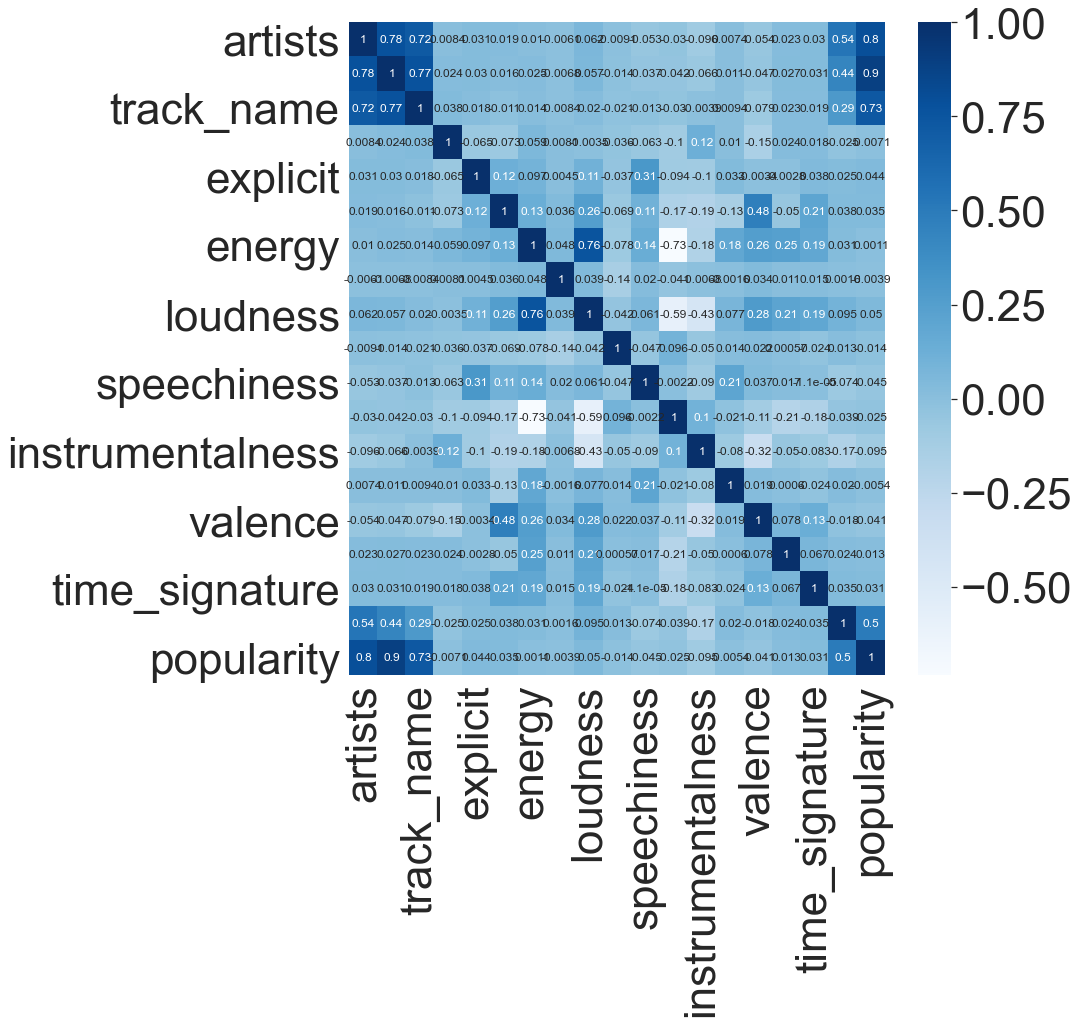

In [22]:


target = "popularity"
X = data.loc[:, data.columns != target]
y = data.loc[:, data.columns == target]

encodeColumns = X.select_dtypes(include=['object']).columns.tolist()  #select categorical columns
encoder = ce.LeaveOneOutEncoder(cols = encodeColumns )
#encoder = ce.TargetEncoder(cols = encodeColumns, smoothing = 300 )
enc = encoder.fit(X, y)
X = enc.transform(X)


X[target] = y

corr = X.corr()
sns.heatmap(corr, cmap="Blues", annot=True, annot_kws={"size":12})
sns.set(rc={"figure.figsize": (12, 12)})
sns.set(font_scale=4)


In [23]:
# remove all the features with correlation coefficient with populairy < |0.01|
data.drop(columns= ["duration_ms", "key", "mode", "liveness", "album_name" ], inplace = True)


# With categorical features

In [24]:
target = "popularity" #target featur
encoder = ce.LeaveOneOutEncoder()
catCol = ["artists", "track_name", "explicit", "track_genre"]

artists             31437
track_name          73608
popularity            101
explicit                2
danceability         1174
energy               2083
loudness            19480
speechiness          1489
acousticness         5061
instrumentalness     5346
valence              1790
tempo               45653
time_signature          5
track_genre           114
dtype: int64

In [25]:
k = 5
k_Fold=KFold(n_splits=k,shuffle=True)

MSEs = []
R2s = []

for alpha in np.arange(0, 5000, 100):

    valR2Scores = []
    valMSE = []
    w = RidgeRegression(alpha)

    
    for trainI, testI in  k_Fold.split(data):
        #Split i-th fold into training and validation set
        train = data.loc[trainI]
        test = data.loc[testI]
        #Separate target variable from feature variables
        train_X = train.loc[:, train.columns != target]
        train_y = train[target].astype(np.int64)
        val_X = test.loc[:, test.columns != target]
        val_y = test[target].astype(np.int64)
        tmp = train_X
        #Encoding of categorical features
        enc = encoder.fit(train_X, train_y)
        train_X = enc.transform(train_X)           
        val_X = enc.transform(val_X)
        break
        #Normalize: mean=0, std=1
        mean_X = train_X.mean()
        std_X = train_X.std()

        train_X = (train_X - mean_X) / std_X       
        val_X = (val_X - mean_X) / std_X
        
        train_X = train_X.astype(np.float64)
        val_X = val_X.astype(np.float64)    
        train_y = train_y.astype(np.float64)
        val_y = val_y.astype(np.float64)
        #Compute predicto
        w.fit(train_X, train_y)

        #Evaluate fold performance
        predictions = w.predict(val_X)

        rescaledValMSE = w.mseScore(val_y,predictions)
        rescaledValR2Score = w.r2Score(val_y,predictions)
        valMSE.append(rescaledValMSE)
        valR2Scores.append(rescaledValR2Score)
        
    estimMSE = sum(valMSE) / k
    estimR2Score =sum(valR2Scores) / k  
    print("Alpha: {} | MSEscore: {} | R2score: {}".format(alpha, estimMSE, estimR2Score))
    MSEs.append(estimMSE)
    R2s.append(estimR2Score)
    break

Alpha: 0 | MSEscore: 0.0 | R2score: 0.0


In [39]:
tmp['artists'].value_counts()['Gen Hoshino']

9

In [43]:
sum(tmp['track_name'].value_counts() == 1)

48255

In [34]:
tmp.head(20)

,artists,track_name,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,time_signature,track_genre
0,Gen Hoshino,Comedy,False,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.7150,87.917,4,acoustic
1,Ben Woodward,Ghost - Acoustic,False,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.2670,77.489,4,acoustic
3,Kina Grannis,Can't Help Falling In Love,False,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1430,181.740,3,acoustic
5,Tyrone Wells,Days I Will Remember,False,0.688,0.4810,-8.807,0.1050,0.2890,0.000000,0.6660,98.017,4,acoustic
7,Jason Mraz,I'm Yours,False,0.703,0.4440,-9.331,0.0417,0.5590,0.000000,0.7120,150.960,4,acoustic
8,Jason Mraz;Colbie Caillat,Lucky,False,0.625,0.4140,-8.700,0.0369,0.2940,0.000000,0.6690,130.088,4,acoustic
9,Ross Copperman,Hunger,False,0.442,0.6320,-6.770,0.0295,0.4260,0.004190,0.1960,78.899,4,acoustic
10,Zack Tabudlo,Give Me Your Forever,False,0.627,0.3630,-8.127,0.0291,0.2790,0.000000,0.3010,99.905,4,acoustic
11,Jason Mraz,I Won't Give Up,False,0.483,0.3030,-10.058,0.0429,0.6940,0.000000,0.1390,133.406,3,acoustic
12,Dan Berk,Solo,False,0.489,0.3140,-9.245,0.0331,0.7490,0.000000,0.6070,124.234,4,acoustic


In [28]:
train_X.head()

,artists,track_name,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,time_signature,track_genre
0,59.888889,73.000000,False,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.715,87.917,4,42.820253
1,44.000000,55.000000,False,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.267,77.489,4,42.820253
3,53.769231,57.600000,False,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.143,181.740,3,42.820253
5,48.250000,48.666667,False,0.688,0.4810,-8.807,0.1050,0.2890,0.000000,0.666,98.017,4,42.820253
7,27.450000,73.750000,False,0.703,0.4440,-9.331,0.0417,0.5590,0.000000,0.712,150.960,4,42.820253


Text(0.5, 1.0, 'Regression with categorical features: RMSE vs alpha')

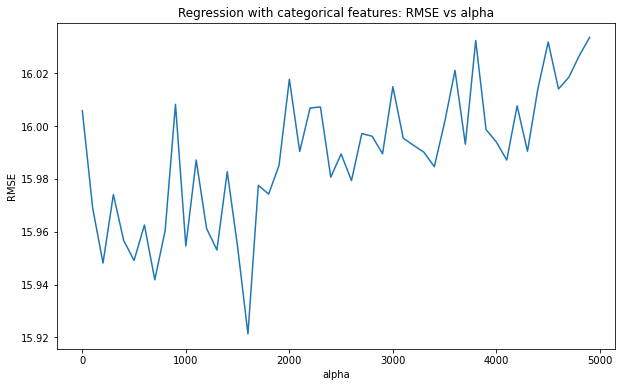

In [8]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,  5000, 100), MSEs)
plt.ylabel("RMSE")
plt.xlabel("alpha")
plt.title("Regression with categorical features: RMSE vs alpha")

Text(0.5, 1.0, 'Regression with categorical features: R2score vs alpha')

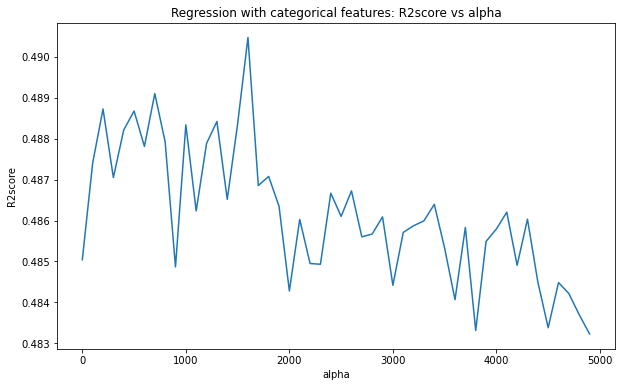

In [9]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,  5000, 100), R2s)
plt.ylabel("R2score")
plt.xlabel("alpha")
plt.title("Regression with categorical features: R2score vs alpha")

In [ ]:
max(R2s)

# Only numerical features

In [33]:
boolean_col = "explicit" #boolean feature
target = "popularity" #target feature


#Separate features from target
data.drop(columns = catCol, inplace = True)
data

,album_name,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Comedy,73,230666,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4
1,Ghost (Acoustic),55,149610,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4
2,To Begin Again,57,210826,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4
3,Crazy Rich Asians (Original Motion Picture Sou...,71,201933,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3
4,Hold On,82,198853,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,#mindfulness - Soft Rain for Mindful Meditatio...,21,384999,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5
113996,#mindfulness - Soft Rain for Mindful Meditatio...,22,385000,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4
113997,Best Of,22,271466,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4
113998,Change Your World,41,283893,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4


In [12]:
k = 5
k_Fold=KFold(n_splits=k,shuffle=True)

alphas = np.arange(0, 5000, 100)

MSEsnum = []
R2snum = []

for alpha in alphas:

    valR2Scores = []
    valMSE = []
    w = RidgeRegression(alpha)
    for trainI, testI in  k_Fold.split(data):
        #Split i-th fold into training and validation set
        train = data.T[trainI].T
        test = data.T[testI].T
        #Separate target variable from feature variables
        train_X = train.loc[:, train.columns != target]
        train_y = train[target].astype(np.int64)
        val_X = test.loc[:, test.columns != target]
        val_y = test[target].astype(np.int64)
        
        #Normalize: mean=0, std=1
        mean_X = train_X.mean()
        std_X = train_X.std()

        train_X = np.divide(np.add(train_X, -mean_X), std_X)       #normalize: mean=0, std=1
        val_X = np.divide(np.add(val_X, -mean_X), std_X)

        train_X = train_X.astype(np.float64)
        val_X = val_X.astype(np.float64)
        
        #Compute predictor
        w.fit(train_X, train_y)

        #Evaluate fold performance
        predictions = w.predict(val_X)

        rescaledValMSE = w.mseScore(val_y,predictions)
        rescaledValR2Score = w.r2Score(val_y,predictions)
        valMSE.append(rescaledValMSE)
        valR2Scores.append(rescaledValR2Score)
        

    print("Alpha: {} | MSEscore: {} | R2score: {}".format(alpha, estimMSE, estimR2Score))
    estimMSE = sum(valMSE) / k
    estimR2Score =sum(valR2Scores) / k  
    MSEsnum.append(estimMSE)
    R2snum.append(estimR2Score)

    

    
    
    

Alpha: 0 | MSEscore: 16.03352633056255 | R2score: 0.48322665176565743
Alpha: 100 | MSEscore: 22.114883250856316 | R2score: 0.016884689656952
Alpha: 200 | MSEscore: 22.1139739056357 | R2score: 0.016987989716963026
Alpha: 300 | MSEscore: 22.113555558000225 | R2score: 0.017052770393829998
Alpha: 400 | MSEscore: 22.11372145603107 | R2score: 0.01704079461192585
Alpha: 500 | MSEscore: 22.11324581969126 | R2score: 0.01704705994556408
Alpha: 600 | MSEscore: 22.11375680284699 | R2score: 0.017016497478564728
Alpha: 700 | MSEscore: 22.112999679836143 | R2score: 0.017070370636697585
Alpha: 800 | MSEscore: 22.113369542556587 | R2score: 0.017077741625322117
Alpha: 900 | MSEscore: 22.11377961444136 | R2score: 0.017042272476926957
Alpha: 1000 | MSEscore: 22.113649122251577 | R2score: 0.017060039162134367
Alpha: 1100 | MSEscore: 22.113844383730488 | R2score: 0.0170117781910736
Alpha: 1200 | MSEscore: 22.113329575729505 | R2score: 0.01706887821056389
Alpha: 1300 | MSEscore: 22.114954478491146 | R2score:

Text(0.5, 1.0, 'Regression with categorical features: RMSE vs alpha')

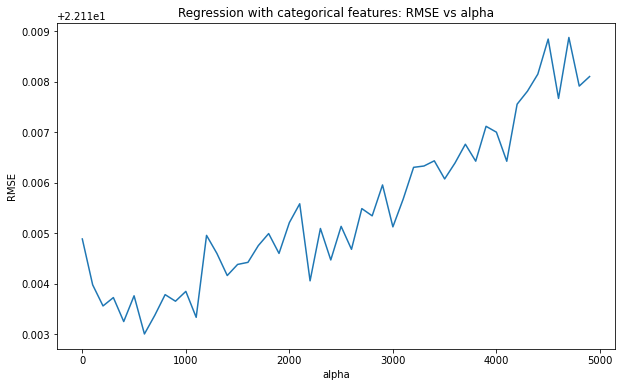

In [13]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,  5000, 100), MSEsnum)
plt.ylabel("RMSE")
plt.xlabel("alpha")
plt.title("Regression with categorical features: RMSE vs alpha")

Text(0.5, 1.0, 'Regression with categorical features: RMSE vs alpha')

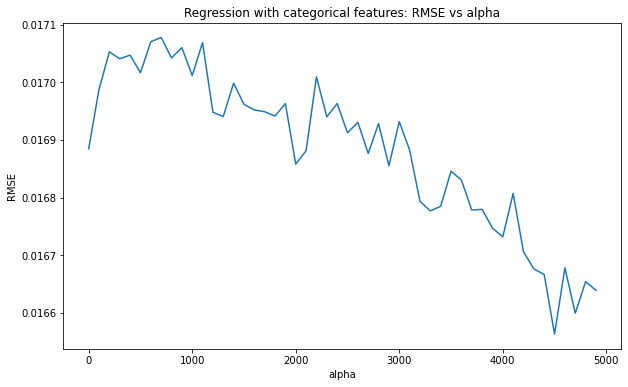

In [14]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,  5000, 100), R2snum)
plt.ylabel("RMSE")
plt.xlabel("alpha")
plt.title("Regression with categorical features: RMSE vs alpha")

In [ ]:
max(R2snum)